<a href="https://colab.research.google.com/github/priyankachaudhari08/BA-775-Final-Project/blob/main/BostonGloryMidterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Frisbee Data Dynamics**

**Team Members: Audrey Sellers, Mohamad Ali Saadeddine, Priyanka Chaudhari**

## **Problem Statement and Scope**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Collection and Preprocessing:**

####We source our data from UFA API. We build a low cost, easily managed ETL infrastructure(Google Cloud Function) to automate ingestion of the data from these sources into our Data Warehouse(Google Big Query) and event triggers to update dashboards and models.


## **Game Dataset**

In [ ]:
import requests
import pandas as pd
import json
from urllib import request
import os
import pandas_gbq
from google.oauth2 import service_account
import functions_framework

TABLE_ID = "boston-glory-analytics.audl.games2"
PROJECT_ID = "boston-glory-analytics"

def get_credentials():
    credentials = service_account.Credentials.from_service_account_file("boston_glory.json")
    return credentials

def process_api_call(response):
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        print(response.text)

def make_ufa_games_request(year):
    url = 'https://www.backend.ufastats.com/api/v1/games'
    params = {
        'date': f'{year}',
    }
    response = requests.get(url, params=params)
    return response

def get_ufa_games_data(year):
    response = make_ufa_games_request(year)
    data = process_api_call(response)
    return data

def make_games_dataframe(years=[2023, 2024]):
    all_games_data = []

    for year in years:
        game_data = get_ufa_games_data(year)
        json_data = game_data['data']

        for game in json_data:
            game['year'] = year
            all_games_data.append(game)

    df_game_data = pd.DataFrame(all_games_data)
    return df_game_data

def bigquery_ingress(df, TABLE_ID, PROJECT_ID, credentials):
    pandas_gbq.to_gbq(
        df, TABLE_ID, project_id=PROJECT_ID, if_exists="replace", credentials=credentials
    )

@functions_framework.http
def hello_http(request):
    ### Get the data:
    print("Entry")
    df = make_games_dataframe()
    print("Got data")

    ### Drop the 'year' column
    df = df.drop(columns=['year'])
    print("Dropped 'year' column")

    ### Get service account credentials
    credentials = get_credentials()
    print("Got credentials")

    ### Ingress to bigquery
    bigquery_ingress(df, TABLE_ID, PROJECT_ID, credentials)
    print("Loaded BQ")
    return "Complete!"


##**Players Dataset**

In [ ]:
import requests
import pandas as pd
import json
from urllib import request
import os
import pandas_gbq
from google.oauth2 import service_account
import functions_framework

TABLE_ID = "boston-glory-analytics.audl.players2"
PROJECT_ID = "boston-glory-analytics"

def get_credentials():
    credentials = service_account.Credentials.from_service_account_file("boston_glory.json")
    return credentials

def process_api_call(response):
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        print(response.text)

def make_ufa_players_request(year):
    url = f'https://www.backend.ufastats.com/api/v1/players?years={year}'
    response = requests.get(url)
    return response

def get_ufa_players_data(year):
    response = make_ufa_players_request(year)
    data = process_api_call(response)
    return data

def make_players_dataframe(years=[2023, 2024]):
    all_players_data = []

    for year in years:
        players = get_ufa_players_data(year)
        players = players['data']

        for player in players:
            for team in player.get('teams', []):
                player_pk = f"{player['playerID']}{team['teamID']}{year}"
                team_pk = f"{team['teamID']}{year}"
                row_data = {
                    'playerPK': player_pk,
                    'teamPK': team_pk,
                    'year': year,
                    'playerID': player['playerID'],
                    'firstName': player['firstName'],
                    'lastName': player['lastName'],
                    'teamID': team['teamID'],
                    'jerseyNumber': team.get('jerseyNumber', None)
                }
                all_players_data.append(row_data)

    players_df = pd.DataFrame(all_players_data)

    # Drop columns that contain 'active' in their names
    players_df = players_df.loc[:, ~players_df.columns.str.contains('active')]

    return players_df

def bigquery_ingress(df, TABLE_ID, PROJECT_ID, credentials):
    pandas_gbq.to_gbq(df, TABLE_ID, project_id=PROJECT_ID, if_exists="replace", credentials=credentials)

@functions_framework.http
def hello_http(request):
    ### Get the data:
    print("Entry")
    df = make_players_dataframe()
    print("Got data")
    ### Get service account credentials
    credentials = get_credentials()
    print("Got credentials")
    ### Ingress to bigquery
    bigquery_ingress(df, TABLE_ID, PROJECT_ID, credentials)
    print("Loaded BQ")
    return "Complete!"


# Sample Data Uploading

First upload the overall statistic tables from BigQuery results. Then upload the Boston Glory exclusive statistics.

In [ ]:
import pandas as pd

# Overall
defensive_weak_percentage = pd.read_csv('/content/DEFWEAK.csv')
points_per_game = pd.read_csv('/content/TOTALPPG.csv')
playtime_ppg = pd.read_csv('/content/PLAYTIME.csv')

# Glory
glorydf= pd.read_csv('/content/glorydata.csv')
glory_defweak= pd.read_csv('/content/GLORYDEFWEAK.csv')
glory_ppg= pd.read_csv('/content/GLORYPPG.csv')
glory_playtime= pd.read_csv('/content/GLORYPLAYTIME.csv')

# Points Per Game (Goals + Assists)

In [ ]:
glory_ppg

,firstName,lastName,teamID,total_points
0,Tanner,Halkyard,glory,11
1,Tanner,Halkyard,glory,10
2,Benjamin,Sadok,glory,9
3,Orion,Cable,glory,9
4,Ray,Tetreault,glory,9
...,...,...,...,...
809,Zachary,Burpee,glory,0
810,Zachary,Burpee,glory,0
811,Zachary,Burpee,glory,0
812,Zachary,Burpee,glory,0


In [ ]:
glory_ppg['total_points'].mean()

1.2702702702702702

In [ ]:
plus5points = glory_ppg[glory_ppg['total_points'] > 5]
plus5points['total_points'].mean()

7.16

<ipython-input-7-60d9e5577cc1>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='total_points', y='lastName', data=plus5points, palette='Blues_r', ci=None)
<ipython-input-7-60d9e5577cc1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_points', y='lastName', data=plus5points, palette='Blues_r', ci=None)


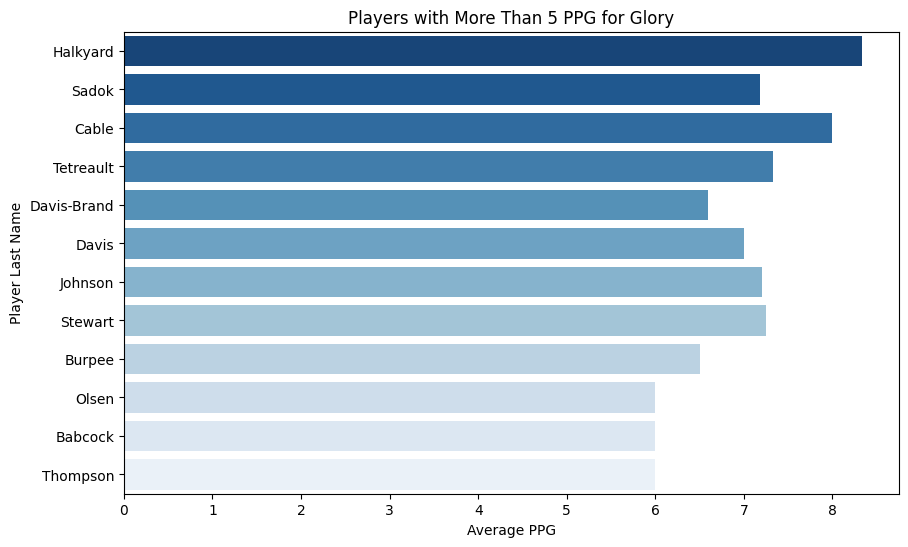

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='total_points', y='lastName', data=plus5points, palette='Blues_r', ci=None)
plt.xlabel('Average PPG')
plt.ylabel('Player Last Name')
plt.title('Players with More Than 5 PPG for Glory')
plt.show()

The top 5 players in scoring for Boston Glory are Halkyard, Cable, Sadok, and Tetrault. Each of them score **at least 7 points** (goals + assists) per game.

In [ ]:
points_per_game

,firstName,lastName,teamID,total_points
0,Jordan,Huston,cannons,22
1,Kevin,Quinlan,royal,19
2,Mark,Burton,cascades,18
3,Steve,Armitage,rush,17
4,Tyler,DeGirolamo,breeze,17
...,...,...,...,...
64338,Tommy,Lin,flamethrowers,0
64339,Tommy,Lin,flamethrowers,0
64340,Tommy,Lin,flamethrowers,0
64341,Tommy,Lin,flamethrowers,0


In [ ]:
points_per_game['total_points'].value_counts()

total_points
0     22614
1     12601
2      9515
3      6606
4      4559
5      3148
6      2047
7      1306
8       847
9       498
10      303
11      135
12       68
13       35
14       34
15       13
16        7
17        4
19        1
18        1
22        1
Name: count, dtype: int64

In [ ]:
morethan5ppg = points_per_game[points_per_game['total_points'] > 5]
morethan5ppg['total_points'].mean()

7.429811320754717

<ipython-input-11-2215e5e51eaf>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='teamID', y='total_points', data=team_total_points, palette=colors)


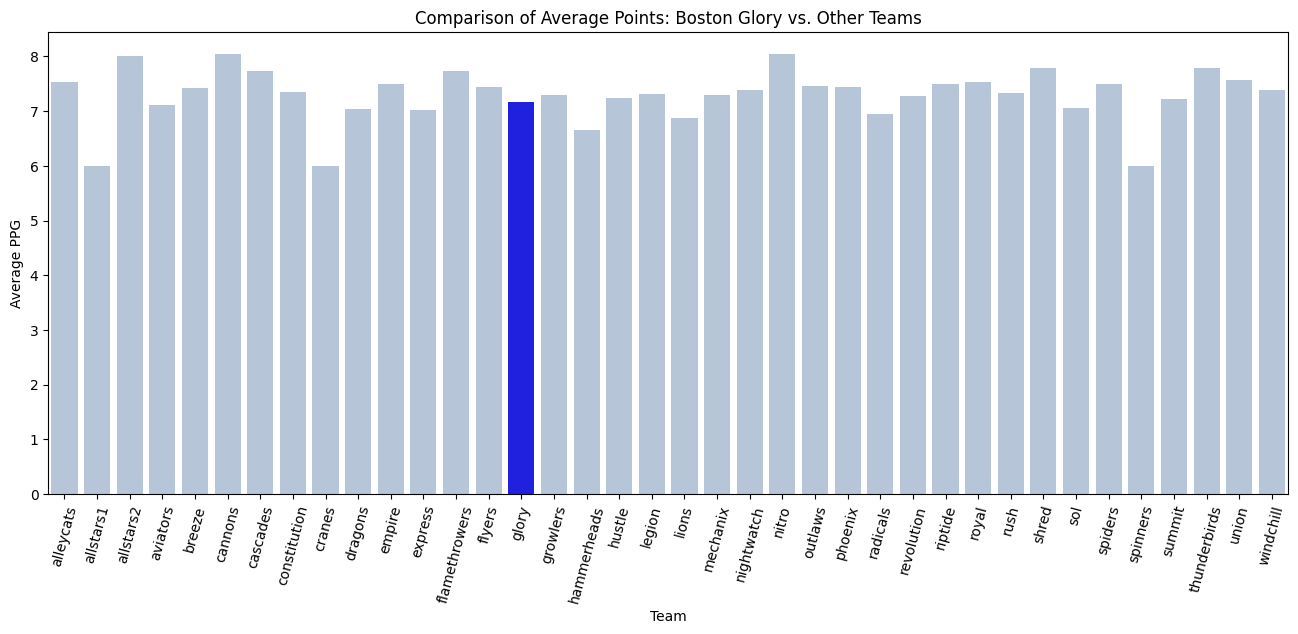

In [ ]:
threshold = 5
morethan5 = points_per_game[points_per_game['total_points'] > threshold]

grouped_df = morethan5.groupby('teamID')

# Calculate mean points for each team
team_total_points = grouped_df['total_points'].mean().reset_index()

colors = ['blue' if team == 'glory' else 'lightsteelblue' for team in team_total_points['teamID']]

plt.figure(figsize=(16, 6))
sns.barplot(x='teamID', y='total_points', data=team_total_points, palette=colors)
plt.xlabel('Team')
plt.ylabel('Average PPG')
plt.title('Comparison of Average Points: Boston Glory vs. Other Teams')
plt.xticks(rotation=75)
plt.show()

After deciding a threshold of 5 points per game to filter out players with less than 5 points, as they skewed the data, we found that Boston Glory scores less Points per Game (Goals + Assists), at **7.16 PPG**, compared to a league average of **7.43 PPG**, indicating a need for **offensive improvement**.

# Defensive Weakness

On average, each player gives up x amount on average of goals on defense per game.

In [ ]:
glory_defweak

,firstName,lastName,teamID,dPointsScored,dPointsPlayed,defensive_production
0,Braden,Eberhard,glory,1,1,1.0
1,Benjamin,Sadok,glory,1,1,1.0
2,Cody,McInnis,glory,1,1,1.0
3,Nick,Thompson,glory,3,3,1.0
4,Topher,Davis,glory,1,1,1.0
...,...,...,...,...,...,...
363,Ryan,Turner,glory,0,3,0.0
364,Henry,Laseter,glory,0,6,0.0
365,Ivan,Tran,glory,0,18,0.0
366,Kuochuan,Ponzio,glory,0,9,0.0


In [ ]:
glory_defweak['defensive_production'].mean()

0.21627571819952343

In [ ]:
defensive_weak_percentage

,firstName,lastName,teamID,defensive_production
0,Isaac,Jeffries,revolution,8.000000
1,Chris,Powers,revolution,4.666667
2,Chris,Powers,revolution,4.500000
3,Eddie,Mack,revolution,4.000000
4,Jeff,Kula,revolution,3.333333
...,...,...,...,...
51595,Sam,Swink,flamethrowers,0.000000
51596,Tommy,Lin,flamethrowers,0.000000
51597,Tommy,Lin,flamethrowers,0.000000
51598,Tommy,Lin,flamethrowers,0.000000


In [ ]:
defensive_weak_percentage['defensive_production'].mean()

0.3143262011211762

In [ ]:
defensive_weak_percentage[defensive_weak_percentage['teamID'] == 'glory']

,firstName,lastName,teamID,defensive_production
241,Braden,Eberhard,glory,1.0
242,Benjamin,Sadok,glory,1.0
243,Cody,McInnis,glory,1.0
244,Nick,Thompson,glory,1.0
245,Topher,Davis,glory,1.0
...,...,...,...,...
43759,Ryan,Turner,glory,0.0
43760,Henry,Laseter,glory,0.0
43761,Ivan,Tran,glory,0.0
43762,Kuochuan,Ponzio,glory,0.0


<ipython-input-18-204ddb536c11>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='teamID', y='defensive_production', data=defensive_weak_percentage, palette=colors, showfliers=False)
<ipython-input-18-204ddb536c11>:4: UserWarning: The palette list has more values (51600) than needed (39), which may not be intended.
  sns.boxplot(x='teamID', y='defensive_production', data=defensive_weak_percentage, palette=colors, showfliers=False)


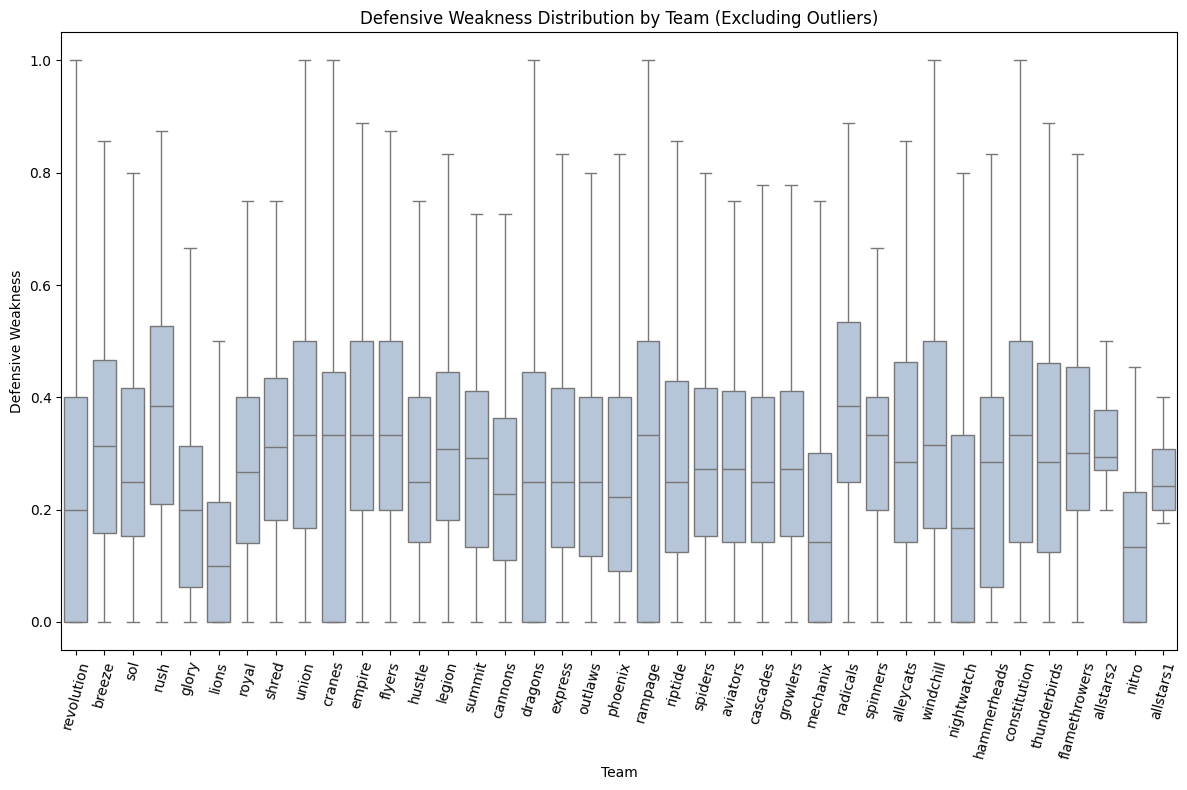

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 8))
colors = ['blue' if team == 'glory' else 'lightsteelblue' for team in defensive_weak_percentage['teamID']]

sns.boxplot(x='teamID', y='defensive_production', data=defensive_weak_percentage, palette=colors, showfliers=False)

plt.title('Defensive Weakness Distribution by Team (Excluding Outliers)')
plt.xlabel('Team')
plt.ylabel('Defensive Weakness')

plt.xticks(rotation=75)

plt.tight_layout()

plt.show()
plt.figure(figsize=(12, 8))

# How is playing time correlated with performance metrics?

In [ ]:
glory_playtime

,firstName,lastName,teamID,secondsPlayed,goals,assists,goals_per_second,PPG,points_per_second
0,Tanner,Halkyard,glory,1408,6,5,0.004261,11,0.007812
1,Tanner,Halkyard,glory,1297,6,4,0.004626,10,0.007710
2,Tanner,Halkyard,glory,1155,5,3,0.004329,8,0.006926
3,Cole,Davis-Brand,glory,581,1,3,0.001721,4,0.006885
4,Topher,Davis,glory,888,5,1,0.005631,6,0.006757
...,...,...,...,...,...,...,...,...,...
463,Ryan,Woodhouse,glory,538,0,0,0.000000,0,0.000000
464,Ryan,Woodhouse,glory,909,0,0,0.000000,0,0.000000
465,Ryan,Woodhouse,glory,885,0,0,0.000000,0,0.000000
466,Ryan,Woodhouse,glory,552,0,0,0.000000,0,0.000000


<Figure size 1000x200 with 0 Axes>

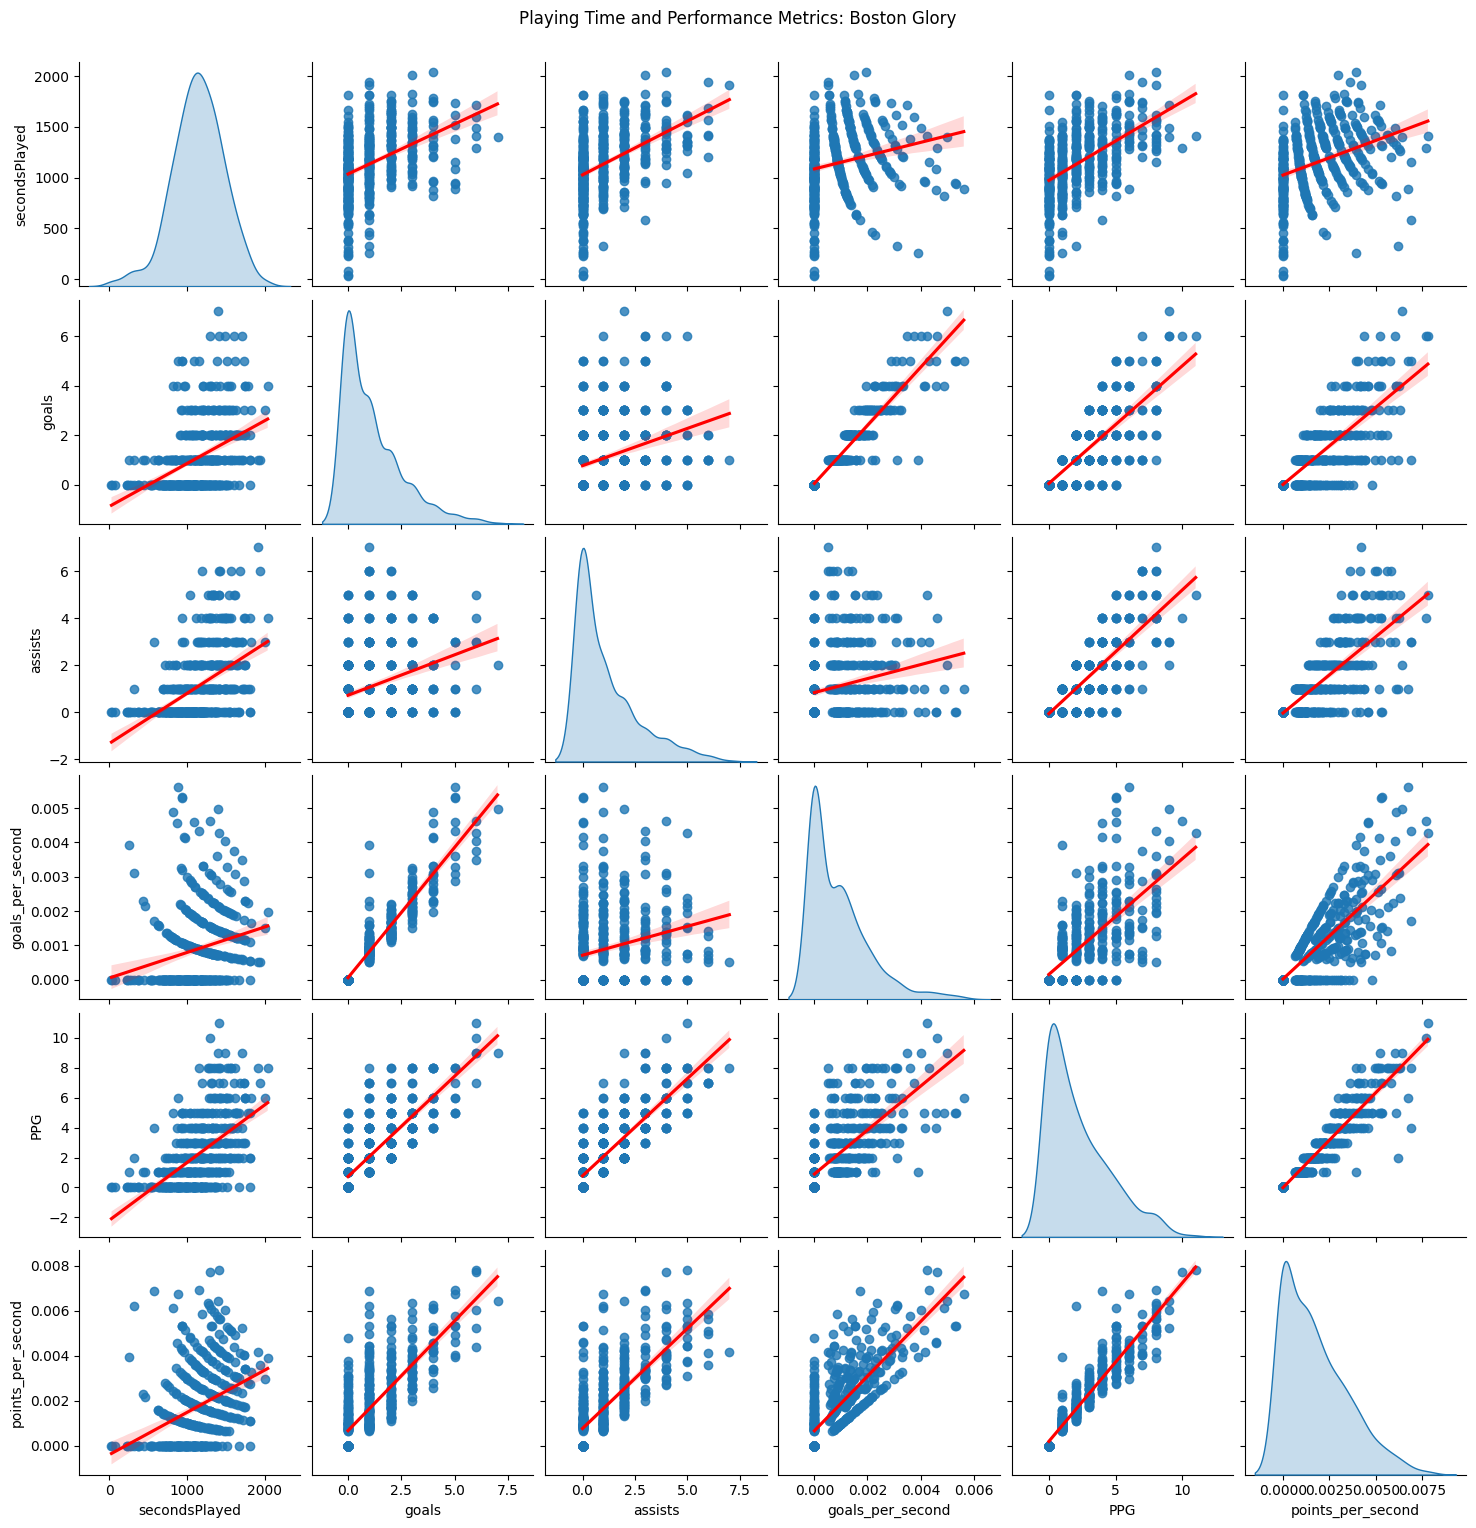

In [ ]:
columns = ['secondsPlayed', 'goals', 'assists', 'goals_per_second', 'PPG', 'points_per_second']
playtime_pairplot = glory_playtime[columns]


plt.figure(figsize=(10, 2))
sns.pairplot(playtime_pairplot, kind='reg', diag_kind='kde', plot_kws={'line_kws':{'color':'red'}})
plt.suptitle('Playing Time and Performance Metrics: Boston Glory', y=1.02)
plt.show()

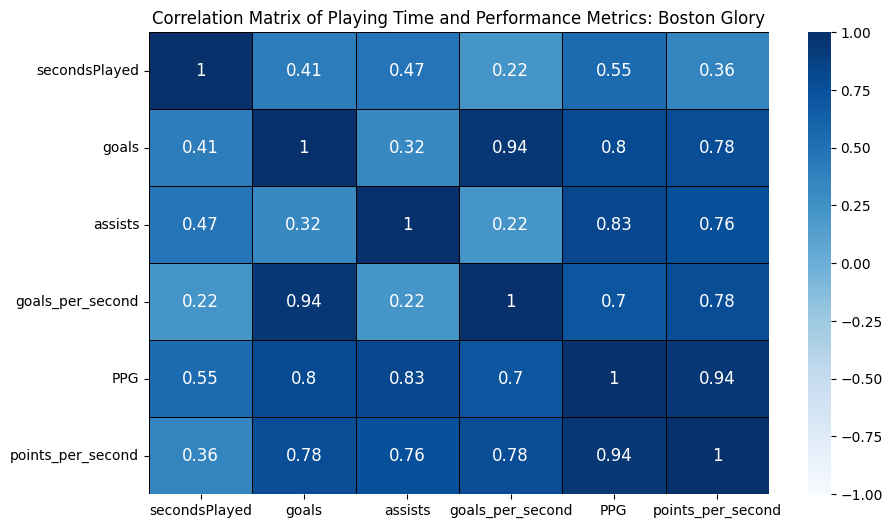

In [ ]:
playtime_corr = glory_playtime[columns]

# Calculating correlation matrix
corr_matrix = playtime_corr.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1, center=0,
            linewidths=0.5, linecolor='black', annot_kws={'fontsize': 12})
plt.title('Correlation Matrix of Playing Time and Performance Metrics: Boston Glory')
plt.show()

In [ ]:
playtime_ppg

,firstName,lastName,teamID,secondsPlayed,goals,assists,goals_per_second,PPG,points_per_second
0,Ryan,Segal,cascades,10,0,1,0.000000,1,0.100000
1,Logan,Weiss,windchill,10,1,0,0.100000,1,0.100000
2,Aaron,Buss,thunderbirds,13,0,1,0.000000,1,0.076923
3,Nick,Wetzel,revolution,21,1,0,0.047619,1,0.047619
4,Andrew,Padula,aviators,24,0,1,0.000000,1,0.041667
...,...,...,...,...,...,...,...,...,...
50255,Tommy,Lin,flamethrowers,227,0,0,0.000000,0,0.000000
50256,Tommy,Lin,flamethrowers,199,0,0,0.000000,0,0.000000
50257,Tommy,Lin,flamethrowers,369,0,0,0.000000,0,0.000000
50258,Tommy,Lin,flamethrowers,534,0,0,0.000000,0,0.000000


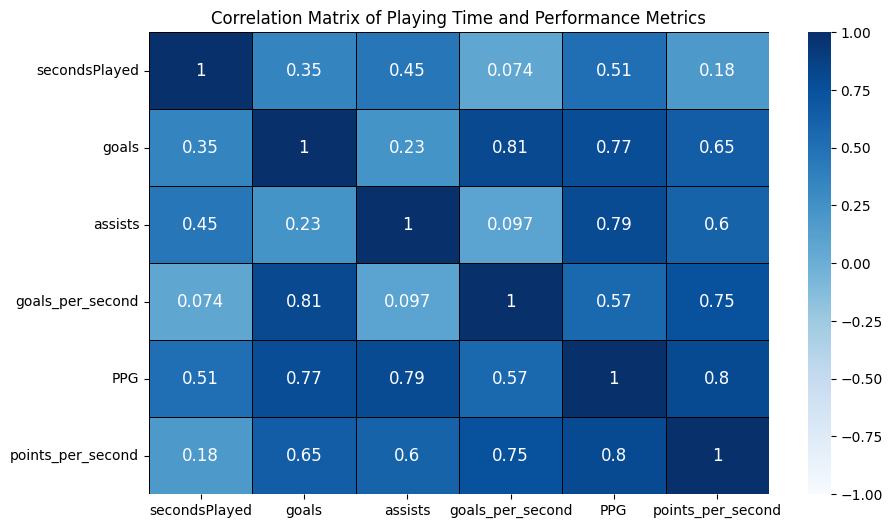

In [ ]:
playtime_corr_overall = playtime_ppg[columns]

corr_matrix_overall = playtime_corr_overall.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_overall, annot=True, cmap='Blues', vmin=-1, vmax=1, center=0,
            linewidths=0.5, linecolor='black', annot_kws={'fontsize': 12})
plt.title('Correlation Matrix of Playing Time and Performance Metrics')
plt.show()

There seems to be a moderate positive overall league correlation with playing time (secondsPlayed) and PPG of **0.51**.

In [ ]:
glorydf

,firstName,lastName,teamID,secondsPlayed,yardsReceived,completion_percentage,goals,throwaway_percentage,throw_yards_per_attempt,yardsThrown,yards_per_reception,assists,goals_per_second,PPG,points_per_second
0,Tanner,Halkyard,glory,1408,389,90.4762,6,4.7619,4.904762,103,13.892857,5,0.004261,11,0.007812
1,Tanner,Halkyard,glory,1297,329,89.4737,6,10.5263,8.631579,164,14.304348,4,0.004626,10,0.007710
2,Tanner,Halkyard,glory,1155,274,100.0000,5,0.0000,6.416667,77,16.117647,3,0.004329,8,0.006926
3,Cole,Davis-Brand,glory,581,119,90.9091,1,9.0909,8.272727,182,5.666667,3,0.001721,4,0.006885
4,Topher,Davis,glory,888,143,100.0000,5,0.0000,12.555556,113,10.214286,1,0.005631,6,0.006757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,Ryan,Woodhouse,glory,538,0,0.0000,0,0.0000,NaN,0,NaN,0,0.000000,0,0.000000
464,Ryan,Woodhouse,glory,909,0,0.0000,0,0.0000,NaN,0,NaN,0,0.000000,0,0.000000
465,Ryan,Woodhouse,glory,885,0,0.0000,0,0.0000,NaN,0,NaN,0,0.000000,0,0.000000
466,Ryan,Woodhouse,glory,552,0,0.0000,0,0.0000,NaN,0,NaN,0,0.000000,0,0.000000


In [ ]:
ppg5_glory= glorydf[glorydf['PPG'] > 5]
ppg5_glory

,firstName,lastName,teamID,secondsPlayed,yardsReceived,completion_percentage,goals,throwaway_percentage,throw_yards_per_attempt,yardsThrown,yards_per_reception,assists,goals_per_second,PPG,points_per_second
0,Tanner,Halkyard,glory,1408,389,90.4762,6,4.7619,4.904762,103,13.892857,5,0.004261,11,0.007812
1,Tanner,Halkyard,glory,1297,329,89.4737,6,10.5263,8.631579,164,14.304348,4,0.004626,10,0.007710
2,Tanner,Halkyard,glory,1155,274,100.0000,5,0.0000,6.416667,77,16.117647,3,0.004329,8,0.006926
4,Topher,Davis,glory,888,143,100.0000,5,0.0000,12.555556,113,10.214286,1,0.005631,6,0.006757
5,Orion,Cable,glory,1403,212,72.7273,7,9.0909,5.000000,55,11.777778,2,0.004989,9,0.006415
6,Tannor,Johnson,glory,1266,192,96.0000,3,4.0000,9.320000,233,7.111111,5,0.002370,8,0.006319
7,Topher,Davis,glory,1282,251,94.1176,4,5.8824,7.764706,132,11.952381,4,0.003120,8,0.006240
10,Topher,Davis,glory,1317,298,89.4737,4,5.2632,10.052632,191,13.545455,4,0.003037,8,0.006074
11,Ray,Tetreault,glory,1488,336,100.0000,6,0.0000,4.714286,99,12.444444,3,0.004032,9,0.006048
12,Benjamin,Sadok,glory,1349,272,97.5000,3,2.5000,11.575000,463,8.000000,5,0.002224,8,0.005930


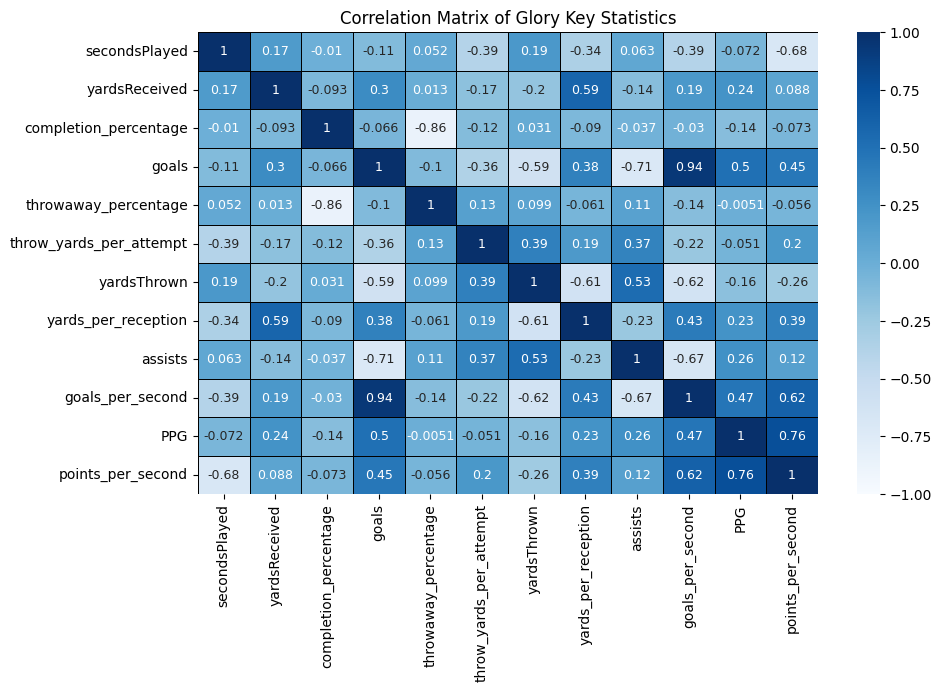

In [ ]:
columns= ['secondsPlayed','yardsReceived','completion_percentage','goals','throwaway_percentage','throw_yards_per_attempt','yardsThrown','yards_per_reception','assists','goals_per_second','PPG','points_per_second']
glorycorr = ppg5_glory[columns]

corr_matrix_glory = glorycorr.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_glory, annot=True, cmap='Blues', vmin=-1, vmax=1, center=0,
            linewidths=0.5, linecolor='black', annot_kws={'fontsize': 9})
plt.title('Correlation Matrix of Glory Key Statistics')
plt.show()

We see relevant positive correlation with PPG for the following attributes: **yardsReceived** and **yards_per_reception**. For negative PPG correlation we see the following attributes: **secondsPlayed** and **yardsThrown**.

Audrey Sellers' section ends.